In [39]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc

import matplotlib.pyplot as plt
import h5py
import obspy
from obspy.signal.filter import envelope
from obspy.clients.fdsn import Client
from glob import glob #is a function that’s used to search for files that match a specific file pattern or name.
import random

from scipy import signal
from scipy.interpolate import interp1d

from csv import writer


In [27]:
def extract_waveforms(cat, file_name):
    
    st = []
    cat_trace = cat['trace_name'].values
    for i in range(len(cat_trace)):

            
 
        f = h5py.File(file_name, 'r')
            
            
        bucket = cat['trace_name'].values[i].split('$')[0]
        ind = int(cat['trace_name'].values[i].split('$')[1].split(',')[0])
        # ENZ
        st.append(f['/data/'+bucket][ind, :3, :18000])
        
    return st

def extract_Z_waveforms(cat, file_name):
    
    st = []
    cat_trace = cat['trace_name'].values
    for i in range(len(cat_trace)):

            
 
        f = h5py.File(file_name, 'r')
            
            
        bucket = cat['trace_name'].values[i].split('$')[0]
        ind = int(cat['trace_name'].values[i].split('$')[1].split(',')[0])
        # ENZ
#         st.append(f['/data/'+bucket][ind, 2, :18000])
        waveforms = f['/data/'+bucket][ind, 2, :18000] # Shouldn't this be 3?
        wave = waveforms[np.newaxis, np.newaxis, :]
        st.append(wave)
        
    return st


def convert_into_traces(stream, cat):
    channels = ['BHE','BHN','BHZ'] 
    
    st = []  
    for i in range(len(stream)):
        for j in range(len(stream[i])):
            tr = obspy.Trace(stream[i][j])
            tr.stats.channel = channels[j]
            tr.stats.station = cat['station_code'].values[i]
            tr.stats.network = cat['station_network_code'].values[i]
            tr.stats.sampling_rate = 100
            tr.stats.starttime = obspy.UTCDateTime(cat['trace_start_time'].values[i])
            
            st.append(tr)
            
    return obspy.Stream(st)


def plot_duration_mag(trace, dur_mag, threshold_low=0.02, threshold_high=0.98, title = 'Thunder Waveforms', init_time = 0, final_time = 150):
    
    duration = []
    
    for j in range(len(trace)):
        
            #fig, axs = plt.subplots(2, 1, figsize = (12, 12))
        
            sampling_rate = 100
            d = trace[j].data[init_time*sampling_rate:final_time*sampling_rate]
            t = trace[j].times()[init_time*sampling_rate:final_time*sampling_rate]
            a = sc.integrate.cumtrapz( d**(2),t,  initial = 0)
            lower_index = np.where(a > a[-1]*(threshold_low))[0][0]
            upper_index = np.where(a > a[-1]*(threshold_high))[0][0]
            dur = t[upper_index] - t[lower_index]
            
            duration.append(dur)
    
    plt.figure(figsize=(15,10))
    plt.plot(dur_mag, duration, 'o')
    plt.yscale('log')
    plt.xlabel('Duration Magnitude', fontsize=15)
    plt.ylabel('Duration [s]', fontsize=15)
    plt.title(title, fontsize=20)
            
    # Show the plot
    plt.show()
    return duration

In [28]:
# collecting waveform data and corresponding catalog.
comcat_file_name = "/data/whd01/yiyu_data/PNWML/comcat_waveforms.hdf5"
comcat_csv_file = "/data/whd01/yiyu_data/PNWML/comcat_metadata.csv"

noise_file_name = "/data/whd01/yiyu_data/PNWML/noise_waveforms.hdf5"
noise_csv_file = "/data/whd01/yiyu_data/PNWML/noise_metadata.csv"

In [29]:
## collecting the catalog and storing it. 
cat_comcat = pd.read_csv(comcat_csv_file)
cat_noise = pd.read_csv(noise_csv_file)

In [30]:
## making SNR in correct format
snrs_comcat = []
for i in range(len(cat_comcat['trace_snr_db'])):
    snrs_comcat.append(np.array(cat_comcat['trace_snr_db'].values[i].split('|')).astype('float')[-1])
    

In [31]:
cat_comcat['snr_final'] = snrs_comcat

In [32]:
cat_earthquake = cat_comcat[cat_comcat['source_type'] == 'earthquake']

In [33]:
cat_earthquake_good = cat_earthquake.sort_values(by = 'snr_final', ascending = False).iloc[0:2000]

### Make a flipped data of the mixed waveforms

In [3]:
# Read the waveform data downsampled to 20 Hz for mixed waveforms
with h5py.File('mixed_signal_1min_norm.h5', 'r') as f:
    mixed_wave = f['quake'][:] # Add this pair of brakets to extract only the np array
    print(mixed_wave.shape)

(2000, 1, 1200)


In [9]:
cat_earthquake_test = pd.read_csv('highest_snrs_durations_peak_amp.csv')

In [5]:
# Make zeros to contain the mixed waveforms that is flipped
mixed_wave_flipped = np.zeros((2000,1,1200))

In [6]:
# Contain the flipped data into the zeros
for i in range(len(mixed_wave_flipped)):
    mixed_wave_flipped[i,0,:] = mixed_wave[i,0,:] * (-1)

In [8]:
# Make sure the waveforms are flipped
print(mixed_wave[0])
print(mixed_wave_flipped[0])

print(mixed_wave[100])
print(mixed_wave_flipped[100])

[[ 4.92026413e-04  4.61513536e-04  6.47166581e-04 ... -8.22560771e-01
  -1.14980544e+00 -1.04702846e+00]]
[[-4.92026413e-04 -4.61513536e-04 -6.47166581e-04 ...  8.22560771e-01
   1.14980544e+00  1.04702846e+00]]
[[-0.02381263 -0.02394575 -0.01058758 ... -1.79824997 -3.2047242
   1.04613433]]
[[ 0.02381263  0.02394575  0.01058758 ...  1.79824997  3.2047242
  -1.04613433]]


In [12]:
# Combine the original array and flipped array into a single array
mixed_signal_1min_norm_and_flip = np.concatenate((mixed_wave, mixed_wave_flipped), axis=0)
print(mixed_signal_1min_norm_and_flip.shape)

(4000, 1, 1200)


In [10]:
cat_earthquake_test

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,event_id,source_origin_time,source_latitude_deg,source_longitude_deg,source_type,source_depth_km,preferred_source_magnitude,...,source_local_magnitude,source_local_magnitude_uncertainty,source_duration_magnitude,source_duration_magnitude_uncertainty,source_hand_magnitude,trace_missing_channel,trace_has_offset,snr_final,durations,durations_peak_amp
0,0,0,119605,uw61362346,2018-01-03T08:36:25.940000Z,46.256,-122.056,earthquake,10.230,3.82,...,3.82,0.149,4.20,0.306,NaN,0,0,76.523,12.47,11.19
1,1,1,58318,uw60563331,2013-08-03T02:11:16.250000Z,46.327,-122.391,earthquake,13.199,3.12,...,3.12,0.275,3.12,0.336,NaN,0,0,73.933,8.47,5.94
2,2,2,127484,uw61504942,2018-11-19T11:09:13.050000Z,47.698,-123.552,earthquake,39.320,4.08,...,4.08,0.163,4.11,0.349,NaN,0,0,73.801,17.23,15.45
3,3,3,19376,uw10753338,2008-07-31T05:02:43.130000Z,48.152,-122.748,earthquake,55.880,3.87,...,3.87,0.134,3.89,0.246,NaN,0,0,73.368,22.84,14.49
4,4,4,73030,uw60881241,2014-09-17T10:06:12.840000Z,47.561,-123.009,earthquake,16.201,3.98,...,3.98,0.176,4.14,0.325,NaN,0,0,73.215,6.16,5.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,1995,8697,uw10656733,2005-07-02T22:39:31.040000Z,48.136,-122.482,earthquake,16.500,2.20,...,NaN,NaN,2.20,0.030,NaN,2,0,43.633,20.98,20.56
1996,1996,1996,43232,uw10823553,2011-09-04T04:13:39.540000Z,46.411,-119.260,earthquake,1.605,3.21,...,3.21,0.119,3.70,0.040,NaN,0,0,43.632,14.04,11.16
1997,1997,1997,147871,uw61625752,2020-06-03T17:13:50.350000Z,46.844,-121.762,earthquake,0.310,1.10,...,1.10,0.098,0.29,0.105,NaN,0,0,43.630,3.65,2.85
1998,1998,1998,109477,uw61267487,2017-05-18T18:15:32.560000Z,47.593,-122.589,earthquake,25.110,2.50,...,2.50,0.286,2.57,0.297,NaN,0,0,43.629,9.74,5.69


In [26]:
# Make a file of the flipped waveforms
with h5py.File('mixed_signal_1min_norm_and_flip.h5', 'w') as f:
    f.create_dataset('quake', data=mixed_signal_1min_norm_and_flip)

### Strech, shift, and add noise to the waveforms from the original waveform 

In [36]:
array_earthquake = extract_waveforms(cat_earthquake_good, comcat_file_name)
array_earthquake = convert_into_traces(array_earthquake, cat_earthquake_good).select(channel = '*HZ')
trace  = array_earthquake

In [79]:
init_time=0
final_time=150 
threshold_low=0.02
threshold_high=0.98
time_before_p=10 
time_after_p= 60
total_time = 60
sampling_rate = 100

npts = int(total_time * sampling_rate)


array = np.zeros((4000, 1, 6000))
durations = np.zeros(4000)


#     correction = int((npts - len(wave_new)) / 2)
#     n2 = np.sum(np.square(wave_new))
#     corr = sgn.correlate(wave1, wave_new) / np.sqrt(n1 * n2)

for i in range(len(trace)):
#     fig, axs = plt.subplots(2, 1, figsize = (5, 5), gridspec_kw={'height_ratios': [1, 3]}, sharex=True)    
        
    t = trace[i].times()[init_time*sampling_rate:final_time*sampling_rate]
    d = trace[i].data[init_time*sampling_rate:final_time*sampling_rate]
    a = sc.integrate.cumtrapz( d**(2),t,  initial = 0)   
    
    
    

    #Find the P-wave onset
    lower_index = np.where(a > a[-1]*(threshold_low))[0][0]
#     upper_index = np.where(a > a[-1]*(threshold_high))[0][0]
   
    lower_time_index =  lower_index - time_before_p * sampling_rate
    upper_time_index =  lower_index + time_after_p * sampling_rate
    
    new_d = d[lower_time_index:upper_time_index]
    new_t = t[lower_time_index:upper_time_index]
    new_a = a[lower_time_index:upper_time_index]
    
    
    trace_abs = abs(new_d)
    peak_amp = max(trace_abs)
    peak_amp_index = np.where(trace_abs == peak_amp)

#     lower_index = np.where(new_a > new_a[-1]*(threshold_low))[0][0]
    upper_index = np.where(new_a > new_a[-1]*(threshold_high))[0][0]
    
    dur = new_t[upper_index] - new_t[peak_amp_index]

    durations[i*2] = dur[0]
    
    array[i*2,0,:] = new_d[0:npts]
    
    interp_f = interp1d(new_t, new_d, bounds_error=False, fill_value=0.)
    dt = new_t[1] - new_t[0]
    
    

    # Stretching
    ratio = np.random.rand(1)[0]+1 
    new_pre_p = int(time_before_p *ratio *sampling_rate)

    dt_new = dt / ratio
    time_new = np.arange(new_t[0], new_t[-1], dt_new)
    wave_new = interp_f(time_new)
    
    # Cropping wave_new to be 7000 points
    st_pt  = int(new_pre_p-10*sampling_rate)
    max_shift = 5 * sampling_rate
    shift_pt = np.random.rand(1)*max_shift
    
    # Shifting the time window
    st_pt_new = int(st_pt+shift_pt)
    wave_new = wave_new[st_pt_new:st_pt_new+npts]

    
    print(wave_new.shape,ratio)
    
    
    print(new_pre_p,time_before_p, npts, ratio, sampling_rate)

    array[i*2+1,0,:] = wave_new
    durations[i*2+1] = dur[0]*ratio
    
   

(6000,) 1.1658183021066293
1165 10 6000 1.1658183021066293 100
(6000,) 1.7817964146626912
1781 10 6000 1.7817964146626912 100
(6000,) 1.376750727202968
1376 10 6000 1.376750727202968 100
(6000,) 1.0208344567914942
1020 10 6000 1.0208344567914942 100
(6000,) 1.0480477164208746
1048 10 6000 1.0480477164208746 100
(6000,) 1.7606633112704837
1760 10 6000 1.7606633112704837 100
(6000,) 1.0111926134591425
1011 10 6000 1.0111926134591425 100
(6000,) 1.2790892809217178
1279 10 6000 1.2790892809217178 100
(6000,) 1.248609195369569
1248 10 6000 1.248609195369569 100
(6000,) 1.7766257979354467
1776 10 6000 1.7766257979354467 100
(6000,) 1.0081166258130514
1008 10 6000 1.0081166258130514 100
(6000,) 1.8701425468693864
1870 10 6000 1.8701425468693864 100
(6000,) 1.618768084043397
1618 10 6000 1.618768084043397 100
(6000,) 1.7813352218273928
1781 10 6000 1.7813352218273928 100
(6000,) 1.1560644228540413
1156 10 6000 1.1560644228540413 100
(6000,) 1.0056863163454712
1005 10 6000 1.0056863163454712 10

(6000,) 1.7319863031748484
1731 10 6000 1.7319863031748484 100
(6000,) 1.1991982839080249
1199 10 6000 1.1991982839080249 100
(6000,) 1.732392480797441
1732 10 6000 1.732392480797441 100
(6000,) 1.4124840267594916
1412 10 6000 1.4124840267594916 100
(6000,) 1.5274506934442975
1527 10 6000 1.5274506934442975 100
(6000,) 1.8094912262208338
1809 10 6000 1.8094912262208338 100
(6000,) 1.1750468102042182
1175 10 6000 1.1750468102042182 100
(6000,) 1.6658549135128418
1665 10 6000 1.6658549135128418 100
(6000,) 1.5975000457962352
1597 10 6000 1.5975000457962352 100
(6000,) 1.7153668487011606
1715 10 6000 1.7153668487011606 100
(6000,) 1.3408668602298177
1340 10 6000 1.3408668602298177 100
(6000,) 1.0400278495192201
1040 10 6000 1.0400278495192201 100
(6000,) 1.2698990676176063
1269 10 6000 1.2698990676176063 100
(6000,) 1.4531628260602765
1453 10 6000 1.4531628260602765 100
(6000,) 1.2662039912965009
1266 10 6000 1.2662039912965009 100
(6000,) 1.632319362130658
1632 10 6000 1.632319362130658 

(6000,) 1.4638896915874122
1463 10 6000 1.4638896915874122 100
(6000,) 1.6201638036694723
1620 10 6000 1.6201638036694723 100
(6000,) 1.2538687634345052
1253 10 6000 1.2538687634345052 100
(6000,) 1.614415256467359
1614 10 6000 1.614415256467359 100
(6000,) 1.2704296789828529
1270 10 6000 1.2704296789828529 100
(6000,) 1.74657657751828
1746 10 6000 1.74657657751828 100
(6000,) 1.9380304232181507
1938 10 6000 1.9380304232181507 100
(6000,) 1.8856582769926484
1885 10 6000 1.8856582769926484 100
(6000,) 1.8010887340120956
1801 10 6000 1.8010887340120956 100
(6000,) 1.1270554954420673
1127 10 6000 1.1270554954420673 100
(6000,) 1.2119486085130013
1211 10 6000 1.2119486085130013 100
(6000,) 1.843750259103424
1843 10 6000 1.843750259103424 100
(6000,) 1.572328221546575
1572 10 6000 1.572328221546575 100
(6000,) 1.2681397540483226
1268 10 6000 1.2681397540483226 100
(6000,) 1.0482845475034996
1048 10 6000 1.0482845475034996 100
(6000,) 1.3995303377920663
1399 10 6000 1.3995303377920663 100
(6

(6000,) 1.0403462858149273
1040 10 6000 1.0403462858149273 100
(6000,) 1.720793609124035
1720 10 6000 1.720793609124035 100
(6000,) 1.53904291894781
1539 10 6000 1.53904291894781 100
(6000,) 1.5522996308042751
1552 10 6000 1.5522996308042751 100
(6000,) 1.811343013355529
1811 10 6000 1.811343013355529 100
(6000,) 1.3732445596692022
1373 10 6000 1.3732445596692022 100
(6000,) 1.5084062133113274
1508 10 6000 1.5084062133113274 100
(6000,) 1.215295468781635
1215 10 6000 1.215295468781635 100
(6000,) 1.4352203356107571
1435 10 6000 1.4352203356107571 100
(6000,) 1.1116756194956658
1111 10 6000 1.1116756194956658 100
(6000,) 1.89946303293186
1899 10 6000 1.89946303293186 100
(6000,) 1.3058336294025936
1305 10 6000 1.3058336294025936 100
(6000,) 1.802800004118499
1802 10 6000 1.802800004118499 100
(6000,) 1.7348138224406187
1734 10 6000 1.7348138224406187 100
(6000,) 1.3247072587542548
1324 10 6000 1.3247072587542548 100
(6000,) 1.742940397189968
1742 10 6000 1.742940397189968 100
(6000,) 1.

(6000,) 1.5910142020438056
1591 10 6000 1.5910142020438056 100
(6000,) 1.852905557971909
1852 10 6000 1.852905557971909 100
(6000,) 1.815319542819807
1815 10 6000 1.815319542819807 100
(6000,) 1.1941464667695594
1194 10 6000 1.1941464667695594 100
(6000,) 1.950494823601565
1950 10 6000 1.950494823601565 100
(6000,) 1.1665487215036947
1166 10 6000 1.1665487215036947 100
(6000,) 1.1501497191749865
1150 10 6000 1.1501497191749865 100
(6000,) 1.507077842497297
1507 10 6000 1.507077842497297 100
(6000,) 1.1365128572838064
1136 10 6000 1.1365128572838064 100
(6000,) 1.7897136046647768
1789 10 6000 1.7897136046647768 100
(6000,) 1.1877547215705808
1187 10 6000 1.1877547215705808 100
(6000,) 1.1706834992116462
1170 10 6000 1.1706834992116462 100
(6000,) 1.1830589003528027
1183 10 6000 1.1830589003528027 100
(6000,) 1.057142356906967
1057 10 6000 1.057142356906967 100
(6000,) 1.9070521268174887
1907 10 6000 1.9070521268174887 100
(6000,) 1.3490206245333125
1349 10 6000 1.3490206245333125 100
(6

(6000,) 1.1343007020019447
1134 10 6000 1.1343007020019447 100
(6000,) 1.8291394835493242
1829 10 6000 1.8291394835493242 100
(6000,) 1.862257102324029
1862 10 6000 1.862257102324029 100
(6000,) 1.168474067531598
1168 10 6000 1.168474067531598 100
(6000,) 1.7066479907158199
1706 10 6000 1.7066479907158199 100
(6000,) 1.6716581740910985
1671 10 6000 1.6716581740910985 100
(6000,) 1.7529107361319922
1752 10 6000 1.7529107361319922 100
(6000,) 1.1318791229283147
1131 10 6000 1.1318791229283147 100
(6000,) 1.341441293721185
1341 10 6000 1.341441293721185 100
(6000,) 1.852784172568679
1852 10 6000 1.852784172568679 100
(6000,) 1.509430785875972
1509 10 6000 1.509430785875972 100
(6000,) 1.432136774164725
1432 10 6000 1.432136774164725 100
(6000,) 1.2350076713733533
1235 10 6000 1.2350076713733533 100
(6000,) 1.0004343222449865
1000 10 6000 1.0004343222449865 100
(6000,) 1.3532397645507541
1353 10 6000 1.3532397645507541 100
(6000,) 1.5506552101115703
1550 10 6000 1.5506552101115703 100
(600

(6000,) 1.0585217558720599
1058 10 6000 1.0585217558720599 100
(6000,) 1.1868608190195897
1186 10 6000 1.1868608190195897 100
(6000,) 1.7069099715018665
1706 10 6000 1.7069099715018665 100
(6000,) 1.4723270950522296
1472 10 6000 1.4723270950522296 100
(6000,) 1.9834781112736333
1983 10 6000 1.9834781112736333 100
(6000,) 1.4983302281667183
1498 10 6000 1.4983302281667183 100
(6000,) 1.0689945720859313
1068 10 6000 1.0689945720859313 100
(6000,) 1.2745344294074161
1274 10 6000 1.2745344294074161 100
(6000,) 1.5241878247885579
1524 10 6000 1.5241878247885579 100
(6000,) 1.0754260354514753
1075 10 6000 1.0754260354514753 100
(6000,) 1.267270134898856
1267 10 6000 1.267270134898856 100
(6000,) 1.2803189568469486
1280 10 6000 1.2803189568469486 100
(6000,) 1.2432308764947186
1243 10 6000 1.2432308764947186 100
(6000,) 1.9384348654515355
1938 10 6000 1.9384348654515355 100
(6000,) 1.3673389506455542
1367 10 6000 1.3673389506455542 100
(6000,) 1.6940599420613687
1694 10 6000 1.694059942061368

(6000,) 1.3708845400036764
1370 10 6000 1.3708845400036764 100
(6000,) 1.0279125600750327
1027 10 6000 1.0279125600750327 100
(6000,) 1.3045023588074578
1304 10 6000 1.3045023588074578 100
(6000,) 1.5549656083918393
1554 10 6000 1.5549656083918393 100
(6000,) 1.1912418713358164
1191 10 6000 1.1912418713358164 100
(6000,) 1.7400548597541063
1740 10 6000 1.7400548597541063 100
(6000,) 1.4384072032716706
1438 10 6000 1.4384072032716706 100
(6000,) 1.1807920420103568
1180 10 6000 1.1807920420103568 100
(6000,) 1.785947646118975
1785 10 6000 1.785947646118975 100
(6000,) 1.9527872076036985
1952 10 6000 1.9527872076036985 100
(6000,) 1.3350756316701586
1335 10 6000 1.3350756316701586 100
(6000,) 1.6066693556223848
1606 10 6000 1.6066693556223848 100
(6000,) 1.8649289489738128
1864 10 6000 1.8649289489738128 100
(6000,) 1.0725744568163469
1072 10 6000 1.0725744568163469 100
(6000,) 1.1631699636189055
1163 10 6000 1.1631699636189055 100
(6000,) 1.2519893849792378
1251 10 6000 1.251989384979237

(6000,) 1.4912962690344962
1491 10 6000 1.4912962690344962 100
(6000,) 1.0233046027909212
1023 10 6000 1.0233046027909212 100
(6000,) 1.9011459922628353
1901 10 6000 1.9011459922628353 100
(6000,) 1.6507376109959606
1650 10 6000 1.6507376109959606 100
(6000,) 1.2137011135168534
1213 10 6000 1.2137011135168534 100
(6000,) 1.8052367835224894
1805 10 6000 1.8052367835224894 100
(6000,) 1.5245605130557423
1524 10 6000 1.5245605130557423 100
(6000,) 1.46244209368318
1462 10 6000 1.46244209368318 100
(6000,) 1.3004283945458694
1300 10 6000 1.3004283945458694 100
(6000,) 1.241385523499866
1241 10 6000 1.241385523499866 100
(6000,) 1.4814168178021545
1481 10 6000 1.4814168178021545 100
(6000,) 1.8738171719207433
1873 10 6000 1.8738171719207433 100
(6000,) 1.7319732376374861
1731 10 6000 1.7319732376374861 100
(6000,) 1.4702434855367938
1470 10 6000 1.4702434855367938 100
(6000,) 1.2616144183079057
1261 10 6000 1.2616144183079057 100
(6000,) 1.3386087010797363
1338 10 6000 1.3386087010797363 10

(6000,) 1.8995098411408597
1899 10 6000 1.8995098411408597 100
(6000,) 1.1254798618148927
1125 10 6000 1.1254798618148927 100
(6000,) 1.0037056884247084
1003 10 6000 1.0037056884247084 100
(6000,) 1.8780157103276496
1878 10 6000 1.8780157103276496 100
(6000,) 1.6197504179240547
1619 10 6000 1.6197504179240547 100
(6000,) 1.4699969687756456
1469 10 6000 1.4699969687756456 100
(6000,) 1.9431651132019585
1943 10 6000 1.9431651132019585 100
(6000,) 1.380044674714247
1380 10 6000 1.380044674714247 100
(6000,) 1.767259695297869
1767 10 6000 1.767259695297869 100
(6000,) 1.1546748852984785
1154 10 6000 1.1546748852984785 100
(6000,) 1.8868102554055914
1886 10 6000 1.8868102554055914 100
(6000,) 1.54277012238185
1542 10 6000 1.54277012238185 100
(6000,) 1.1310418404901474
1131 10 6000 1.1310418404901474 100
(6000,) 1.6346461835877828
1634 10 6000 1.6346461835877828 100
(6000,) 1.5294698051234277
1529 10 6000 1.5294698051234277 100
(6000,) 1.1647186917382364
1164 10 6000 1.1647186917382364 100


(6000,) 1.3311475228035659
1331 10 6000 1.3311475228035659 100
(6000,) 1.6208756964314692
1620 10 6000 1.6208756964314692 100
(6000,) 1.9330202097322053
1933 10 6000 1.9330202097322053 100
(6000,) 1.17715633768427
1177 10 6000 1.17715633768427 100
(6000,) 1.897118522930842
1897 10 6000 1.897118522930842 100
(6000,) 1.6998687948725255
1699 10 6000 1.6998687948725255 100
(6000,) 1.7326816914818588
1732 10 6000 1.7326816914818588 100
(6000,) 1.8527973541625193
1852 10 6000 1.8527973541625193 100
(6000,) 1.6435816687137077
1643 10 6000 1.6435816687137077 100
(6000,) 1.4906689129303654
1490 10 6000 1.4906689129303654 100
(6000,) 1.4254624323506706
1425 10 6000 1.4254624323506706 100
(6000,) 1.6886734241259367
1688 10 6000 1.6886734241259367 100
(6000,) 1.6357378864336107
1635 10 6000 1.6357378864336107 100
(6000,) 1.9913736166775005
1991 10 6000 1.9913736166775005 100
(6000,) 1.2454949913469449
1245 10 6000 1.2454949913469449 100
(6000,) 1.0566356153547685
1056 10 6000 1.0566356153547685 10

(6000,) 1.323482352344576
1323 10 6000 1.323482352344576 100
(6000,) 1.203117290783641
1203 10 6000 1.203117290783641 100
(6000,) 1.355705884521718
1355 10 6000 1.355705884521718 100
(6000,) 1.55553731046431
1555 10 6000 1.55553731046431 100
(6000,) 1.4231460431269194
1423 10 6000 1.4231460431269194 100
(6000,) 1.494600670134362
1494 10 6000 1.494600670134362 100
(6000,) 1.9650544722635632
1965 10 6000 1.9650544722635632 100
(6000,) 1.0566428113553856
1056 10 6000 1.0566428113553856 100
(6000,) 1.007921030153415
1007 10 6000 1.007921030153415 100
(6000,) 1.171072677379088
1171 10 6000 1.171072677379088 100
(6000,) 1.6570700574401318
1657 10 6000 1.6570700574401318 100
(6000,) 1.6426523791951368
1642 10 6000 1.6426523791951368 100
(6000,) 1.9286126201622047
1928 10 6000 1.9286126201622047 100
(6000,) 1.4978596385214877
1497 10 6000 1.4978596385214877 100
(6000,) 1.828246515250214
1828 10 6000 1.828246515250214 100
(6000,) 1.9541736362507416
1954 10 6000 1.9541736362507416 100
(6000,) 1.

In [80]:
print(array.shape)

(4000, 1, 6000)


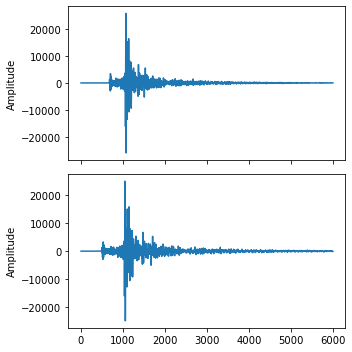

In [117]:
fig, axs = plt.subplots(2, 1, figsize = (5, 5), gridspec_kw={'height_ratios': [1, 1]}, sharex=True)    

# plotting the seismogram
axs[0].plot(np.arange(len(array[100,0])), array[100,0])
axs[0].set_ylabel('Amplitude')
axs[1].plot(np.arange(len(array[101,0])), array[101,0])
axs[1].set_ylabel('Amplitude')
#     axs[0].set_xlim(xlim[0], xlim[1])
# axs[0].axvline(new_t[peak_amp_index], ls = '--', color='black')
# axs[0].axvline(new_t[upper_index], ls = '--', color='black')
# axs[0].set_title(trace[i].stats.channel+' '+'Duration: '+str(np.around(dur, 2))+'s'+' '+"Initial Time: 0s")

        # plotting the energy curve
# axs[1].plot(new_t, new_a)
# axs[1].set_xlabel('Time')
# axs[1].set_ylabel('Energy')        
# #     axs[1].set_xlim(xlim[0], xlim[1])
# axs[1].axvline(new_t[peak_amp_index], ls = '--', color='black')
# axs[1].axvline(new_t[upper_index], ls = '--', color='black')

# fig.suptitle("Waveforms and Durations that Starts at the Peak Amp", fontsize = 20)
fig.tight_layout()

# Show the plot

In [93]:
print(durations[2419])
print(durations[2418])


19.25656316767335
10.110000000000007


(array([4.410e+02, 1.204e+03, 9.680e+02, 6.270e+02, 3.410e+02, 1.640e+02,
        1.100e+02, 7.300e+01, 2.400e+01, 1.400e+01, 1.200e+01, 8.000e+00,
        2.000e+00, 3.000e+00, 5.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([2.00000000e-02, 5.11661433e+00, 1.02132287e+01, 1.53098430e+01,
        2.04064573e+01, 2.55030717e+01, 3.05996860e+01, 3.56963003e+01,
        4.07929147e+01, 4.58895290e+01, 5.09861433e+01, 5.60827576e+01,
        6.11793720e+01, 6.62759863e+01, 7.13726006e+01, 7.64692150e+01,
        8.15658293e+01, 8.66624436e+01, 9.17590580e+01, 9.68556723e+01,
        1.01952287e+02]),
 <BarContainer object of 20 artists>)

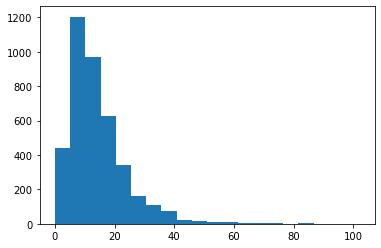

In [135]:
n_bins = 20
plt.hist(durations, n_bins)

In [132]:
# Make a file for the original and augmented durations
# The original and strechted durations are stored alternatively
df_durations = pd.DataFrame(durations,columns=['durations_peak_amp'])
df_durations.to_csv('dur_original_and_strechted.csv', sep=',')

In [133]:
cat_test = pd.read_csv('dur_original_and_strechted.csv')

In [134]:
cat_test

,Unnamed: 0,durations_peak_amp
0,0,11.280000
1,1,13.150430
2,2,5.940000
3,3,10.583871
4,4,15.460000
...,...,...
3995,3995,3.962381
3996,3996,5.720000
3997,3997,9.618100
3998,3998,12.880000


### Add noise

In [95]:
cat_noise[0:5]

,source_type,station_network_code,station_channel_code,station_code,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_sampling_rate_hz,trace_start_time
0,noise,UW,BH,TTW,--,47.694,-121.690,542.0,"bucket1$0,:3,:15001",100,2002-09-21T00:50:20.960000Z
1,noise,UW,HH,ERW,--,48.454,-122.626,387.0,"bucket2$0,:3,:15001",100,2002-09-21T00:50:20.960000Z
2,noise,UW,BH,GNW,--,47.564,-122.825,220.0,"bucket3$0,:3,:15001",100,2002-09-21T00:50:20.960000Z
3,noise,UW,BH,OPC,--,48.100,-123.413,90.0,"bucket4$0,:3,:15001",100,2002-09-21T00:50:20.960000Z
4,noise,UW,BH,GNW,--,47.564,-122.825,220.0,"bucket5$0,:3,:15001",100,2002-09-13T14:54:54.050000Z


In [96]:
cat_noise_shuffle = cat_noise.sample(frac=1)

In [97]:
cat_noise_shuffle[0:5]

,source_type,station_network_code,station_channel_code,station_code,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_sampling_rate_hz,trace_start_time
8277,noise,UW,BH,YACT,--,45.932,-122.419,211.2,"bucket8$806,:3,:15001",100,2009-02-22T05:36:15.050000Z
34472,noise,PB,EH,B202,--,46.245,-122.137,1218.6,"bucket1$3428,:3,:15001",100,2018-11-22T15:46:48.470000Z
8999,noise,UW,EH,HTW,--,47.804,-121.769,833.0,"bucket1$890,:3,:15001",100,2010-07-19T14:18:21.840000Z
19650,noise,PB,EH,B001,--,48.043,-123.131,237.0,"bucket8$1933,:3,:15001",100,2013-03-08T05:15:41.860000Z
15050,noise,US,BH,HAWA,00,46.392,-119.533,364.0,"bucket5$1486,:3,:15001",100,2012-05-28T23:35:28.110000Z


In [98]:
cat_noise_good = cat_noise_shuffle.iloc[0:4000]
print(len(cat_noise_good))

4000


In [99]:
stream_noise = extract_waveforms(cat_noise_good, noise_file_name)
tr_noise = convert_into_traces(stream_noise, cat_noise_good).select(channel = '*HZ')
print(tr_noise[0:10])

10 Trace(s) in Stream:
UW.YACT..BHZ | 2009-02-22T05:36:15.050000Z - 2009-02-22T05:38:45.050000Z | 100.0 Hz, 15001 samples
PB.B202..BHZ | 2018-11-22T15:46:48.470000Z - 2018-11-22T15:49:18.470000Z | 100.0 Hz, 15001 samples
UW.HTW..BHZ  | 2010-07-19T14:18:21.840000Z - 2010-07-19T14:20:51.840000Z | 100.0 Hz, 15001 samples
PB.B001..BHZ | 2013-03-08T05:15:41.860000Z - 2013-03-08T05:18:11.860000Z | 100.0 Hz, 15001 samples
US.HAWA..BHZ | 2012-05-28T23:35:28.110000Z - 2012-05-28T23:37:58.110000Z | 100.0 Hz, 15001 samples
PB.B941..BHZ | 2015-12-26T17:54:41.610000Z - 2015-12-26T17:57:11.610000Z | 100.0 Hz, 15001 samples
TA.E05A..BHZ | 2006-05-28T07:11:14.080000Z - 2006-05-28T07:13:44.080000Z | 100.0 Hz, 15001 samples
PB.B011..BHZ | 2021-09-19T03:00:06.980000Z - 2021-09-19T03:02:36.980000Z | 100.0 Hz, 15001 samples
TA.C05A..BHZ | 2008-01-30T15:01:31.590000Z - 2008-01-30T15:04:01.590000Z | 100.0 Hz, 15001 samples
PB.B013..BHZ | 2012-06-27T04:40:51.030000Z - 2012-06-27T04:43:21.030000Z | 100.0 Hz, 1

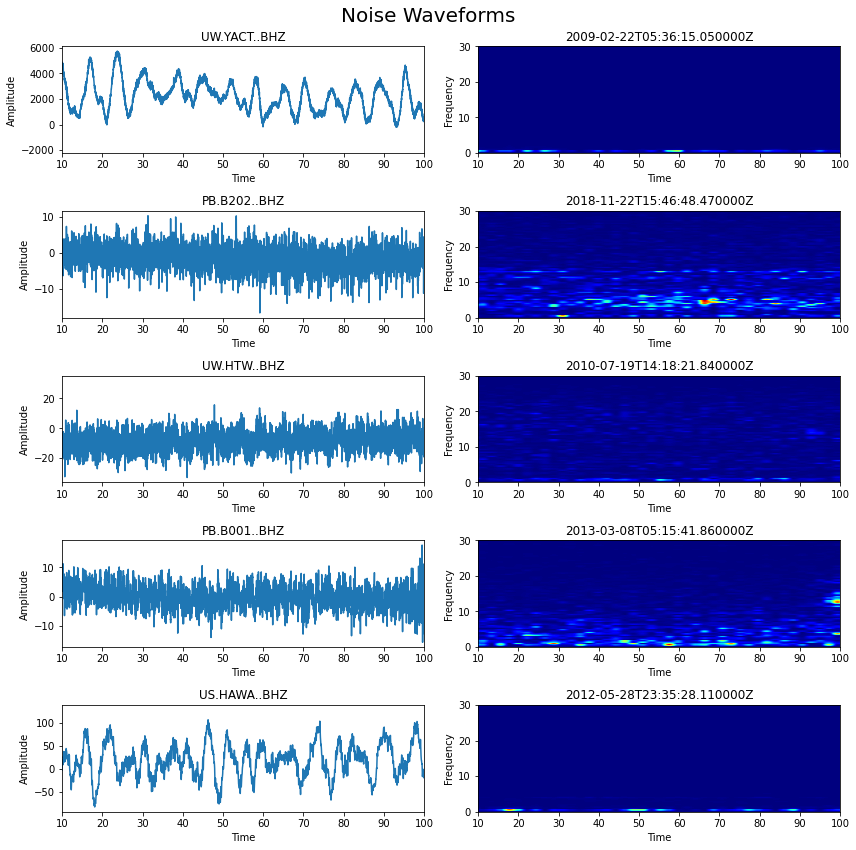

In [100]:
tr_exotic_Z = tr_noise[0:5]
xlim = [10,100]

# Create a figure with subplots
fig, axs = plt.subplots(len(tr_exotic_Z), 2, figsize=(12, 12))

for i in range(len(tr_exotic_Z)):
    time = tr_exotic_Z[i].times()
    # Plot time series in left subplot
    axs[i, 0].plot(time, tr_exotic_Z[i].data)
    axs[i, 0].set_xlabel('Time')
    axs[i, 0].set_ylabel('Amplitude')
    axs[i, 0].set_title(tr_exotic_Z[i].id)
    axs[i,0].set_xlim(xlim[0], xlim[1])

        # Compute and plot spectrogram in right subplot
    f, t_spec, Sxx = signal.spectrogram(tr_exotic_Z[i].data, fs = 100)
    axs[i, 1].imshow(Sxx, aspect='auto', cmap='jet', origin='lower', extent=[t_spec.min(), t_spec.max(), f.min(), f.max()])
    axs[i, 1].set_xlabel('Time')
    axs[i, 1].set_ylabel('Frequency')
    axs[i, 1].set_title(str(tr_exotic_Z[i].stats.starttime))
    axs[i, 1].set_xlim(xlim[0], xlim[1])
    axs[i, 1].set_ylim(0, 30)
    #axs[i, 1].set_yscale('log')

    # Labelling the figure. 
fig.suptitle("Noise Waveforms", fontsize = 20)


    # Adjust the spacing between subplots
plt.tight_layout()

    # Show the plot
plt.show()

In [107]:
init_time=0
final_time=60 
# threshold_low=0.02
# threshold_high=0.98
# time_before_p=10 
# time_after_p=50

trace = tr_noise
n1 = np.zeros((4000,1,6000))

for i in range(len(trace)):
        
    sampling_rate = 100
    t = trace[i].times()[init_time*sampling_rate:final_time*sampling_rate]
    d = trace[i].data[init_time*sampling_rate:final_time*sampling_rate]
    a = sc.integrate.cumtrapz( d**(2),t,  initial = 0)
    
    n1[i][0][:] = d
    
print(n1.shape)

(4000, 1, 6000)


### Downsample the waveform and noise data

In [111]:
# Downsample the waveform data
wave = array
arr_earthquake_downsamp = signal.decimate(wave, 5, axis=2)
print(arr_earthquake_downsamp.shape)

(4000, 1, 1200)


In [112]:
# Downsample the waveform data
noise = n1
arr_noise_downsamp = signal.decimate(noise, 5, axis=2)
print(arr_noise_downsamp.shape)

(4000, 1, 1200)


In [113]:
mixed_signal = np.zeros((4000,1,1200))

In [114]:
for i in range(len(arr_earthquake_downsamp)):
    x = np.random.rand()
    mixed_signal[i,0,:]= arr_earthquake_downsamp[i,0,:] * x + arr_noise_downsamp[i,0,:] * (1-x)

In [115]:
print(mixed_signal.shape)

(4000, 1, 1200)


Text(0, 0.5, 'Amplitude')

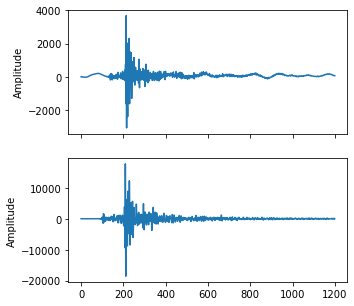

In [118]:
fig, axs = plt.subplots(2, 1, figsize = (5, 5), gridspec_kw={'height_ratios': [1, 1]}, sharex=True)    

# plotting the seismogram
axs[0].plot(np.arange(len(mixed_signal[100,0])), mixed_signal[100,0])
axs[0].set_ylabel('Amplitude')
axs[1].plot(np.arange(len(mixed_signal[101,0])), mixed_signal[101,0])
axs[1].set_ylabel('Amplitude')

In [144]:
mixed_signal_test = arr_earthquake_downsamp[1,0,:] * (1-1) + arr_noise_downsamp[1,0,:] * (1-0)

Text(0, 0.5, 'Amplitude')

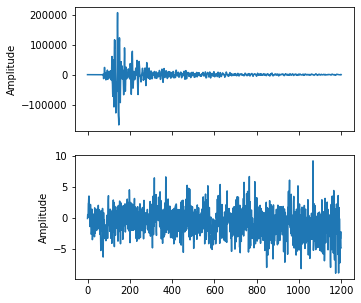

In [145]:
fig, axs = plt.subplots(2, 1, figsize = (5, 5), gridspec_kw={'height_ratios': [1, 1]}, sharex=True)    

# plotting the seismogram
axs[0].plot(np.arange(len(arr_earthquake_downsamp[1,0,:])), arr_earthquake_downsamp[1,0,:])
axs[0].set_ylabel('Amplitude')
axs[1].plot(np.arange(len(mixed_signal_test)),mixed_signal_test)
axs[1].set_ylabel('Amplitude')

(array([  6.,   7.,  19.,  69., 895., 158.,  28.,  11.,   4.,   3.]),
 array([-38570.5442879 , -30394.67700912, -22218.80973034, -14042.94245156,
         -5867.07517277,   2308.79210601,  10484.65938479,  18660.52666358,
         26836.39394236,  35012.26122114,  43188.12849993]),
 <BarContainer object of 10 artists>)

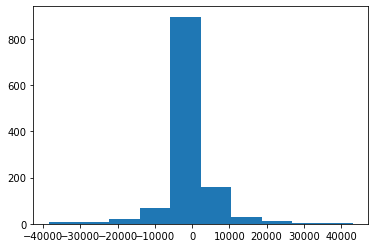

In [142]:
plt.hist(mixed_signal[5][0])

### Make an h5 file of the mixed waveforms

In [119]:
with h5py.File('mixed_signal_1min_original_and_strtch_shf.h5', 'w') as f:
    f.create_dataset('quake', data=mixed_signal)

### Normalized the earthquake data (2001th-3000th) and create a file


In [136]:
# Read the waveform data of stretched and shifted waveforms downsampled to 20 Hz
with h5py.File('mixed_signal_1min_original_and_strtch_shf.h5', 'r') as f:
    wave = f['quake'][:] # Add this pair of brakets to extract only the np array
    print(wave.shape)

(4000, 1, 1200)


In [137]:
mixed_signal_normalized = np.zeros((4000,1,1200))

In [138]:
for i in range(len(wave)):
    mixed_signal_normalized[i,0,:] = (wave[i,0,:] - np.mean(wave[i,0,:])) /(np.std(wave[i,0,:])+1e-12)

(array([  6.,   7.,  19.,  69., 895., 158.,  28.,  11.,   4.,   3.]),
 array([-6.00767534, -4.73440498, -3.46113463, -2.18786427, -0.91459391,
         0.35867644,  1.6319468 ,  2.90521715,  4.17848751,  5.45175787,
         6.72502822]),
 <BarContainer object of 10 artists>)

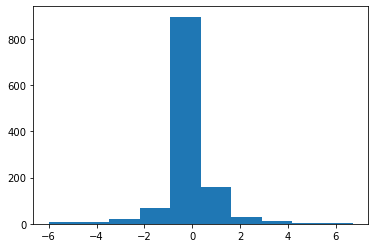

In [141]:
plt.hist(mixed_signal_normalized[5][0])

In [143]:
with h5py.File('mixed_signal_1min_norm_original_and_strtch_shf.h5', 'w') as f:
    f.create_dataset('quake', data=mixed_signal_normalized)